In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from random import randint
from random import random
import matplotlib.pyplot as plt
import time

num_clusters = [7]
# num_clusters = [*range(3, 22, 2)]
svd_components = 600
pca_components = 100
num_bisects = 10
# Distance method should be either 'cosine' or 'euclid'
sse_method = 'cosine'
kmeans_method = 'cosine'
divide_sse = True
pair_min = True
# multi_k_test = True
# k_list = [*range(3,22,2)]

In [2]:
# Create a Cluster class to hold information about each cluster.

class Cluster:
#     def __init__(self, points = [], sse = 0):
#         self.points = points
#         self.sse = sse

    def __init__(self):
        self.points = []
        self.point_ids = []
        self.sse = 0
        self.center = []
        
    def EuclidSSE(self, div_by_size = True):
        self.sse = 0
        for p in self.points:
            self.sse += np.sum(np.square(p - self.center))
        if (div_by_size):
            self.sse = self.sse / len(self.points)
            
    def CosineSSE(self, div_by_size = True):
        self.sse = 0
        center_mag = np.linalg.norm(self.center)
        for p in self.points:
            # I think distance should be 1 minus similarity, and cosine similarity
            # is the dot product divided by the product of the magnitudes.
            p_mag = np.linalg.norm(p)
            self.sse += 1 - (np.dot(p, self.center) / (p_mag * center_mag))
        if (div_by_size):
            self.sse = self.sse / len(self.points)
            
# foo = Cluster()
# foo.center = np.array([1, 1, 3])
# foo.points = np.array([[2, 4, 5]])
# foo.EuclidSSE(False)
# print(foo.sse)



### Read Input Data

In [3]:
# Read data from input file and build a sparse CSR (compressed sparse row) matrix.

data = []
indices = []
indptr = []
count = 0
found = False
# infile = open('sparse_test.dat', 'r')
infile = open('train.dat', 'r')

# whole_file = infile.readlines()
# print(len(whole_file))

for line in infile:
    indptr.append(count)
    
    words = line.split()
    for i in range(0, len(words)-1, 2):
        # Subtracting 1 from column index because it looks like the data file is 1-indexed
        indices.append(int(words[i]) - 1)
        data.append(int(words[i+1]))
        count += 1

indptr.append(count)
infile.close()

csr_data = csr_matrix((data, indices, indptr), shape=(8580, 126373))

print(csr_data.get_shape())
# print(csr_data.getrow(0))

# pd

# print(indptr)
# print(indices)
# print(data)
# print(csr_mat.todense())

(8580, 126373)


### Pre-processing

In [4]:
# Perform dimensionality reduction with SVD

svd = TruncatedSVD(n_components = svd_components)
start = time.time()
svd.fit(csr_data)
duration = time.time() - start
print('SVD fitting completed in', duration, 'seconds')

SVD fitting completed in 116.17998933792114 seconds


Total explained variance ratio: 0.7928186022352349


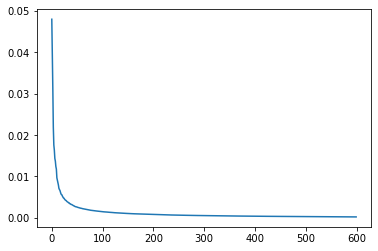

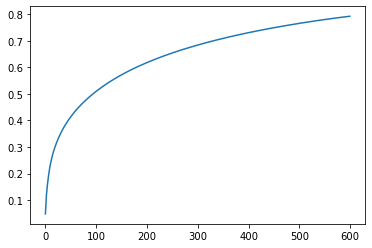

In [5]:
# Analyze the SVD results

# print('Components:', svd.components_)
# print('Explained variance:', svd.explained_variance_)
# print('Explained variance ratio:', svd.explained_variance_ratio_)
# print('Singular values:', svd.singular_values_)
print('Total explained variance ratio:', svd.explained_variance_ratio_.sum())
# print(np.square(svd.singular_values_) / np.sum(np.square(svd.singular_values_)))
# print(svd.explained_variance_ratio_[0])
# print(svd.explained_variance_[0])

plt.plot(svd.explained_variance_ratio_)
plt.show()
cumulative_ratios = np.cumsum(svd.explained_variance_ratio_)
plt.plot(cumulative_ratios)
plt.show()

found_80 = False
found_90 = False
for i,val in enumerate(cumulative_ratios):
    if (val >= 0.8 and not found_80):
        found_80 = True
        print('Index', i, 'is over 80%')
        
    if (val >= 0.9 and not found_90):
        found_90 = True
        print('Index', i, 'is over 90%')
        break

In [6]:
# Transform the input data using the svd fit

reduced_data = np.array(svd.transform(csr_data))
# np.shape(reduced_data)

In [7]:
# Normalize data using L2 norm

norms = np.linalg.norm(reduced_data, axis = 1)
normd_data = reduced_data / norms[:, np.newaxis]

# Add the document id as the first element of each row.
ids = np.array([*range(len(normd_data))])
# normd_data = np.hstack((ids[:,np.newaxis], normd_data))

# print(ids.shape)
# print(normd_data.shape)
# print(type(normd_data))

# print(normd_data[0])


### Also do PCA (experimental)

In [8]:
# Perform dimensionality reduction with PCA

if (pca_components > 0):
    # This is failing with a memory error on the full data set.
    # pca = PCA(n_components = 0.8, svd_solver = 'full')
    # This one just takes forever with the full data set, even for 200 components. I wasn't patient enough to let it finish.
    pca = PCA(n_components = pca_components)

    start = time.time()
    pca.fit(normd_data)
    normd_data = pca.transform(normd_data)
    duration = time.time() - start

    print('PCA fitting completed in', duration, 'seconds')
    print('Total explained variance ratio:', pca.explained_variance_ratio_.sum())

PCA fitting completed in 21.507816553115845 seconds
Total explained variance ratio: 0.5723588353590153


In [10]:
print(type(normd_data))
print(np.shape(normd_data))

<class 'numpy.ndarray'>
(8580, 100)


### Basic K-Means

In [11]:
# Going to try to write my own k-means algorithm with cosine similarity/distance

class MyKMeans:
    def __init__(self, n_clusters = 2, metric = 'cosine', max_iter = 100, start_with_points = True):
        self.n_clusters = n_clusters
        self.metric = metric
        self.max_iter = max_iter
        self.cluster_centers_ = []
        self.labels_ = []
        self.start_with_points = start_with_points
        
    def fit(self, points):
        if (self.metric == 'cosine'):
            # First choose random centroids.
            self.cluster_centers_ = []
            if (self.start_with_points):
                # I'm going to use randomly selected points from the dataset.
                used_points = []
                for i in range(self.n_clusters):
                    rand_point = randint(0, len(points) - 1)
                    # If this point has already been used, choose another.
                    while (rand_point in used_points):
                        rand_point = randint(0, len(points) - 1)
                    self.cluster_centers_.append(points[rand_point].tolist())
                    used_points.append(rand_point)
            else:
                # More-random centroids, not set on actual data points.
                for _ in range(self.n_clusters):
                    # First identify the range of the data.
                    min_vals = np.zeros(points.shape[1])
                    max_vals = np.zeros(points.shape[1])
                    new_center = np.zeros(points.shape[1])
                    for i in range(len(max_vals)):
                        # Iterate through each column, finding the minimum and maximum values.
                        min_vals[i] = min(points[:, i])
                        max_vals[i] = max(points[:, i])
                        # For the center, choose a random value in this range.
                        new_center[i] = (random() * (max_vals[i] - min_vals[i])) + min_vals[i]
                    
                    # If this exact center point has already been chosen, generate another.
                    is_unique = False
                    while (not is_unique):
                        found_same = False
                        for center in self.cluster_centers_:
                            if (np.array_equal(center, new_center)):
                                found_same = True
                                break
                                
                        if (not found_same):
                            is_unique = True
                        else:
                            is_unique = False
                            for i in range(len(max_vals)):
                                new_center[i] = (random() * (max_vals[i] - min_vals[i])) + min_vals[i]
                                
                    self.cluster_centers_.append(new_center)
                
#             old_centers = self.cluster_centers_ + 10
            
            # Repeat until centers don't change anymore.
            for iter_cnt in range(self.max_iter):
                # Assign each point to a centroid/cluster.
                self.labels_ = np.zeros(len(points), dtype=int)
                for i, p in enumerate(points):
                    # Assume that centroid 0 is closest to start, then check all.
                    closest = 0
                    center_mag = np.linalg.norm(self.cluster_centers_[0])
                    p_mag = np.linalg.norm(p)
                    max_similarity = np.dot(self.cluster_centers_[0], p) / (center_mag * p_mag)
                    for k, c in enumerate(self.cluster_centers_):
                        sim = np.dot(c, p) / (np.linalg.norm(c) * np.linalg.norm(p))
                        if (sim > max_similarity):
                            max_similarity = sim
                            closest = k
                    self.labels_[i] = int(closest)

                # Compute new cluster centers as the average of each attribute of the points in the cluster.
                old_centers = self.cluster_centers_
                self.cluster_centers_ = []
                sums = np.array([[0] * len(points[0])] * self.n_clusters, dtype=float)
                counts = np.zeros((self.n_clusters, 1))
                for l, p in zip(self.labels_, points):
#                     print(l, type(l))
#                     print(type(sums[l][0]), sums[l].shape, type(p[0]), p.shape)
                    sums[l] += p
                    counts[l] += 1
                    
#                 print(np.shape(sums), np.shape(counts))
                self.cluster_centers_ = sums / counts
                
#                 print(type(self.cluster_centers_), type(old_centers))
#                 print(type(self.cluster_centers_[0, 0]))
                if (np.array_equal(self.cluster_centers_, old_centers)):
#                     print('K-means converged on iteration', iter_cnt)
                    return self
                
            print('K-means did not converge.')
            return self
            
        else:
            print('ERROR: Unknown distance metric.')
            return None

# maxx = 10
# minn = -10
# foo = (random() * (maxx - minn)) + minn
# print(foo)

### Bisecting K-Means

##### First create a BisectingKMeans class

In [12]:
class BisectingKMeans:
    
    def __init__(self, k):
        self.num_clusters = k
        
    def fit(self, normd_data, ids, num_bisects = 1, kmeans_method = 'cosine', sse_method = 'cosine', pair_min = True):
        # Create a list of clusters and a single cluster which contains all data points
        # cluster = Cluster()
        # cluster.points = normd_data
        clusters = [Cluster()]
        clusters[0].points = normd_data
        clusters[0].point_ids = ids

        # Loop until the desired number of clusters is reached.
        while (len(clusters) < self.num_clusters):

            # Choose the cluster with the highest SSE from the list.
            cluster = clusters[0]
            for c in clusters:
                if (c.sse > cluster.sse):
                    cluster = c
#                 print('SSE = ', c.sse)

            clusters.remove(cluster)

#             print('Chose the cluster with SSE = ', cluster.sse)
#             print()

            # Bisect the cluster using k-means with k = 2. Repeat a few times and take the best result.
            # The random_state argument is a random seed. If set to an integer,
            # the starting centroids will be deterministic.
            candidates = []
            for i in range(num_bisects):
#                 print('Starting bisect number', i)
                if (kmeans_method == 'euclid'):
            #         kmeans = KMeans(n_clusters=2, random_state=0).fit(cluster.points[:,1:])
            #         kmeans = KMeans(n_clusters=2, init='random').fit(cluster.points[:,1:])
                    kmeans = KMeans(n_clusters=2).fit(cluster.points)
                elif (kmeans_method == 'cosine'):
        #             kmeans = MyKMeans(n_clusters=2).fit(cluster.points)
                    kmeans = MyKMeans(n_clusters=2, start_with_points=False).fit(cluster.points)
                else:
                    print('ERROR: Unknown distance method.')

                mask = np.array(kmeans.labels_, dtype = bool)
                inv_mask = np.array([not x for x in mask])

                # Create a new cluster to hold the points from one of the bisections
                new_cluster_0 = Cluster()
                new_cluster_0.points = cluster.points[inv_mask]
                new_cluster_0.point_ids = cluster.point_ids[inv_mask]
                new_cluster_0.center = kmeans.cluster_centers_[0]
                if (sse_method == 'euclid'):
                    new_cluster_0.EuclidSSE(divide_sse)
                elif(sse_method == 'cosine'):
                    new_cluster_0.CosineSSE(divide_sse)
        #         clusters.append(new_cluster)

                # Create a new cluster to hold the rest of the points from the bisection
                new_cluster_1 = Cluster()
                new_cluster_1.points = cluster.points[mask]
                new_cluster_1.point_ids = cluster.point_ids[mask]
                new_cluster_1.center = kmeans.cluster_centers_[1]
                if (sse_method == 'euclid'):
                    new_cluster_1.EuclidSSE(divide_sse)
                elif (sse_method == 'cosine'):
                    new_cluster_1.CosineSSE(divide_sse)

                candidates.append((new_cluster_0, new_cluster_1))
        #         print(len(cluster.points), 'points in cluster')
        #         print(len(new_cluster_0.points), 'points in new_cluster_0')
        #         print(len(new_cluster_1.points), 'points in new_cluster_1')
        #         print(len(new_cluster_0.points)+len(new_cluster_1.points), 'total new points')
        #         print()

            # Look at all of the candidate bisections and choose the pair with the lowest average SSE.
            # Or maybe use the pair with the minimum SSE cluster.
            # Initialize the minimum to the value for the first pair.
            if (pair_min):
                min_sse = min(candidates[0][0].sse, candidates[0][1].sse)
            else:
                min_sse = (candidates[0][0].sse + candidates[0][1].sse) / 2
                
            best_candidate = 0
            for idx, pair in enumerate(candidates):
                if (pair_min):
                    min_in_pair = min(pair[0].sse, pair[1].sse)
            #         print('Average SSE =', avg_sse)
            #         print('Min SSE =', min_in_pair)
                    if (min_in_pair < min_sse):
                        min_sse = min_in_pair
                        best_candidate = idx
                else:
                    avg_sse = (pair[0].sse + pair[1].sse) / 2
                    if (avg_sse < min_sse):
                        min_sse = avg_sse
                        best_candidate = idx

#             print()

            clusters.append(candidates[best_candidate][0])
            clusters.append(candidates[best_candidate][1])
        
        return clusters

##### Then run it

In [13]:
avg_sse_record = []

for k in num_clusters:
    start = time.time()
    clusters = BisectingKMeans(k).fit(normd_data, ids, num_bisects, kmeans_method, sse_method, pair_min)
    print('Duration:', time.time() - start)
    print('Done for k =', k)
    sse_sum = 0
    for c in clusters:
        sse_sum += c.sse
    avg_sse_record.append(sse_sum / len(clusters))

Duration: 230.44902229309082
Done for k = 7


In [14]:
if (len(num_clusters) > 1):
    plt.plot(num_clusters, avg_sse_record)
    plt.xticks(num_clusters)
    plt.xlabel('k')
    plt.ylabel('Avg Cluster SSE')
    plt.title('SSE for Varying k')
    plt.show()

In [15]:
print(len(clusters))
total_points = 0
for i, c in enumerate(clusters):
    print('Cluster', i, 'contains', len(c.points), 'points with an SSE of', c.sse)
    total_points += len(c.points)
print('There are', total_points, 'total points')
# print(np.shape(kmeans.cluster_centers_))
# print(clusters[0].center)
# print(type(cluster.points))
# print(len(normd_data))
# print(clusters[0].points)
# print(kmeans.labels_)
# print(mask)
# print(inv_mask)

7
Cluster 0 contains 1988 points with an SSE of 0.6508630756636195
Cluster 1 contains 1065 points with an SSE of 0.5128240047595665
Cluster 2 contains 981 points with an SSE of 0.524551763999311
Cluster 3 contains 1052 points with an SSE of 0.6120356679185341
Cluster 4 contains 1219 points with an SSE of 0.6247300947322841
Cluster 5 contains 1202 points with an SSE of 0.6624586412231414
Cluster 6 contains 1073 points with an SSE of 0.4724009271504342
There are 8580 total points


In [16]:
# Creating a dictionary with all of the points as a debugging measure, to make sure there are still 8580 distinct point ids.
point_dict = {}
for c in clusters:
    for id in c.point_ids:
        point_dict[id] = True
        
print(len(point_dict))

8580


### Write Results to File

In [17]:
# First need to associate each point with a cluster.

cluster_map = np.zeros(len(normd_data))
# print(len(cluster_map))

for i, c in enumerate(clusters):
    for id in c.point_ids:
        cluster_map[int(id)] = i + 1
#         print(int(p[0]))

# Now I think I should be able to write to the output file.

outfile = open('results.dat', 'w')

cluster_map.tofile(outfile, sep="\n", format="%d")

outfile.close()

### Correlation Measure (abandoned because it takes too long)

### Proximity Heatmap

### Average SSE

In [18]:
euclid_sum = 0
cosine_sum = 0
euclid_sum2 = 0
cosine_sum2 = 0
for c in clusters:
    c.EuclidSSE(div_by_size=True)
    euclid_sum += c.sse
    c.CosineSSE(div_by_size=True)
    cosine_sum += c.sse
    c.EuclidSSE(div_by_size=False)
    euclid_sum2 += c.sse
    c.CosineSSE(div_by_size=False)
    cosine_sum2 += c.sse
    
print('Average Euclidean SSE with division =', euclid_sum / len(clusters))
print('Average Cosine SSE with division =', cosine_sum / len(clusters))
print('Average Euclidean SSE no division =', euclid_sum2 / len(clusters))
print('Average Cosine SSE no division =', cosine_sum2 / len(clusters))

Average Euclidean SSE with division = 0.8187247367552217
Average Cosine SSE with division = 0.579980596492413
Average Euclidean SSE no division = 1013.9291505420989
Average Cosine SSE no division = 723.3182328118746
